In [1]:
from importlib import reload
#reload(Utilities)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats
import datetime
import time

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#---------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
import Plot_Box_sns
import GrubbsTest

In [ ]:
conn_outages = Utilities.get_eemsp_oracle_connection()
conn_aws = Utilities.get_athena_prod_aws_connection()

In [4]:
#dates_of_outages = ['2020-10-26']
#outage_nb = '3695031'

dates_of_outages = ['2020-10-12']
outage_nb = '3643381'

#dates_of_outages = ['2020-10-26']
#outage_nb = '3693321'

In [5]:
fig_num = 0

# ---------------------------------------------------------------
# OUTAGES
# ---------------------------------------------------------------

In [6]:
sql_outage = (
"""
SELECT   DOV.CI_NB, DOV.CMI_NB, DOV.OUTG_REC_NB,DOV.OUTAGE_NB, DOV.DT_ON_TS, DOV.DT_OFF_TS, STEP_DRTN_NB,
         EXTRACT(YEAR FROM DOV.DT_OFF_TS)  AS START_YEAR, 
         DOV.OPERATING_UNIT_ID, DOV1.OPRTG_UNT_NM, DOV.STATE_ABBR_TX, PRIM.PREMISE_NB
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX=DOV1.STATE_ID AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB=DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB
         LEFT OUTER JOIN DOVSADM.DOVS_PREMISE_DIM PRIM ON DOV.OUTG_REC_NB=PRIM.OUTG_REC_NB 
WHERE    DOV.DT_OFF_TS IN ({})
AND  DOV2.INTRPTN_TYP_CD = 'S'
AND  DOV2.CURR_REC_STAT_CD = 'A' 
AND  DOV.MJR_CAUSE_CD <> 'NI' 
AND  DOV.DEVICE_CD <> 85 
AND  DOV.STATE_ABBR_TX = 'OH'
AND  DOV.OUTAGE_NB = {}
"""
).format(','.join(["'{}'".format(x) for x in dates_of_outages]), 
         outage_nb)

print(sql_outage)


SELECT   DOV.CI_NB, DOV.CMI_NB, DOV.OUTG_REC_NB,DOV.OUTAGE_NB, DOV.DT_ON_TS, DOV.DT_OFF_TS, STEP_DRTN_NB,
         EXTRACT(YEAR FROM DOV.DT_OFF_TS)  AS START_YEAR, 
         DOV.OPERATING_UNIT_ID, DOV1.OPRTG_UNT_NM, DOV.STATE_ABBR_TX, PRIM.PREMISE_NB
FROM     DOVSADM.DOVS_OUTAGE_FACT DOV
         LEFT OUTER JOIN DOVSADM.DOVS_MASTER_GEO_DIM DOV1 ON DOV.OPERATING_UNIT_ID=DOV1.OPRTG_UNT_ID AND DOV.STATE_ABBR_TX=DOV1.STATE_ID AND DOV.OPCO_NBR=DOV1.OPCO_ID AND DOV.DISTRICT_NB=DOV1.DISTRICT_ID AND DOV.SRVC_CNTR_NB=DOV1.AREA_ID AND DOV.GIS_CRCT_NB=DOV1.GIS_CIRCUIT_ID
         LEFT OUTER JOIN DOVSADM.DOVS_OUTAGE_ATTRIBUTES_DIM DOV2 ON DOV.OUTG_REC_NB=DOV2.OUTG_REC_NB
         LEFT OUTER JOIN DOVSADM.DOVS_PREMISE_DIM PRIM ON DOV.OUTG_REC_NB=PRIM.OUTG_REC_NB 
WHERE    DOV.DT_OFF_TS IN ('2020-10-12')
AND  DOV2.INTRPTN_TYP_CD = 'S'
AND  DOV2.CURR_REC_STAT_CD = 'A' 
AND  DOV.MJR_CAUSE_CD <> 'NI' 
AND  DOV.DEVICE_CD <> 85 
AND  DOV.STATE_ABBR_TX = 'OH'
AND  DOV.OUTAGE_NB = 3643381



In [7]:
df_outage = pd.read_sql(sql_outage, conn_outages)

In [8]:
df_outage['DT_OFF_TS'].unique()

array(['2020-10-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
df_outage

,CI_NB,CMI_NB,OUTG_REC_NB,OUTAGE_NB,DT_ON_TS,DT_OFF_TS,STEP_DRTN_NB,START_YEAR,OPERATING_UNIT_ID,OPRTG_UNT_NM,STATE_ABBR_TX,PREMISE_NB
0,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,100420620
1,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,100547600
2,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,100683783
3,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,101020620
4,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,101330620
5,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,103520620
6,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,103647600
7,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,103783783
8,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,104120620
9,23.0,2001.0,11947217.0,3643381,2020-10-12 20:45:00,2020-10-12,87.0,2020.0,3,AEP-Ohio,OH,104430620


In [10]:
df_outage['PREMISE_NB'].unique().tolist()

['100420620',
 '100547600',
 '100683783',
 '101020620',
 '101330620',
 '103520620',
 '103647600',
 '103783783',
 '104120620',
 '104430620',
 '105030620',
 '105293783',
 '105710620',
 '106620620',
 '106747600',
 '106883783',
 '107220620',
 '107483783',
 '108130620',
 '108393783',
 '108810620',
 '109720620',
 '109847600']

# ---------------------------------------------------------------
# METER PREMISE
# ---------------------------------------------------------------

In [11]:
# cols_of_interest_met_prem = [
#     'mfr_devc_ser_nbr',
#     'mtr_stat_cd_desc',
#     'first_in_srvc_dt',
#     'phys_inst_dt',
#     'inst_tod_cd',
#     'inst_ts',
#     'last_fld_test_date',
#     'longitude',
#     'latitude',
#     'state_cd', 
#     'prem_nb',
#     'prem_stat_cd',
#     'frst_turn_on_dt',
#     'hsng_ctgy_cd',
#     'srvc_pole_nb',
#     'trsf_pole_nb',
#     'curr_bill_acct_id',
#     'curr_bill_acct_nb',
#     'annual_kwh',
#     'annual_max_dmnd',
#     'latitude_nb',
#     'longitude_nb',
#     'station_nb', 
#     'xfmr_nb'
# ]


cols_of_interest_met_prem = [
    'mfr_devc_ser_nbr',
    'longitude',
    'latitude',
    'state_cd', 
    'prem_nb',
    'srvc_pole_nb',
    'trsf_pole_nb',
    'latitude_nb',
    'longitude_nb',
    'station_nb', 
    'xfmr_nb'
]

In [12]:
sql_metr_prem = (
"""
SELECT {}
FROM default.meter_premise
WHERE state_cd IN ({})
AND prem_nb IN ({})
"""
).format(','.join(cols_of_interest_met_prem), 
         ','.join(["'{}'".format(x) for x in df_outage['STATE_ABBR_TX'].unique().tolist()]), 
         ','.join(["'{}'".format(x) for x in df_outage['PREMISE_NB'].unique().tolist()])) 

print(sql_metr_prem)


SELECT mfr_devc_ser_nbr,longitude,latitude,state_cd,prem_nb,srvc_pole_nb,trsf_pole_nb,latitude_nb,longitude_nb,station_nb,xfmr_nb
FROM default.meter_premise
WHERE state_cd IN ('OH')
AND prem_nb IN ('100420620','100547600','100683783','101020620','101330620','103520620','103647600','103783783','104120620','104430620','105030620','105293783','105710620','106620620','106747600','106883783','107220620','107483783','108130620','108393783','108810620','109720620','109847600')



In [13]:
df_met_prem = pd.read_sql(sql_metr_prem, conn_aws)

In [14]:
if (all(df_met_prem['longitude']==df_met_prem['longitude_nb']) 
    and all(df_met_prem['latitude']==df_met_prem['latitude_nb'])):
    df_met_prem.drop(columns=['longitude_nb', 'latitude_nb'], inplace=True)

# ---------------------------------------------------------------
# USAGE INSTANTANEOUS
# ---------------------------------------------------------------

In [15]:
cols_of_interest_usage_inst = [
    'read_type',
    'serialnumber',
    'aep_premise_nb',
    'timezoneoffset',
    'aep_readtime',
    'aep_readtime_utc',
    'measurement_type',
    'measurement_value',
    'longitude',
    'latitude',
    'aep_opco',
    'aep_read_dt'
]

In [16]:
sql_usage_inst = (
"""
SELECT {}
FROM usage_instantaneous.inst_msr_consume
WHERE aep_opco = 'oh' 
AND aep_state IN ({})
AND aep_premise_nb IN ({})
AND aep_read_dt IN ({})
"""
).format(','.join(cols_of_interest_usage_inst), 
         ','.join(["'{}'".format(x) for x in df_outage['STATE_ABBR_TX'].unique().tolist()]), 
         ','.join(["'{}'".format(x) for x in df_outage['PREMISE_NB'].unique().tolist()]), 
         ','.join(["'{}'".format(x) for x in dates_of_outages]))

print(sql_usage_inst)


SELECT read_type,serialnumber,aep_premise_nb,timezoneoffset,aep_readtime,aep_readtime_utc,measurement_type,measurement_value,longitude,latitude,aep_opco,aep_read_dt
FROM usage_instantaneous.inst_msr_consume
WHERE aep_opco = 'oh' 
AND aep_state IN ('OH')
AND aep_premise_nb IN ('100420620','100547600','100683783','101020620','101330620','103520620','103647600','103783783','104120620','104430620','105030620','105293783','105710620','106620620','106747600','106883783','107220620','107483783','108130620','108393783','108810620','109720620','109847600')
AND aep_read_dt IN ('2020-10-12')



In [17]:
df_usage_inst = pd.read_sql(sql_usage_inst, conn_aws)
df_usage_inst = Utilities_df.remove_prepend_from_columns_in_df(df_usage_inst)

In [18]:
df_usage_inst

,read_type,serialnumber,aep_premise_nb,timezoneoffset,aep_readtime,aep_readtime_utc,measurement_type,measurement_value,longitude,latitude,aep_opco,aep_read_dt
0,mt113_st28_pm_temp_powerquality,769683872,103520620,-04:00,2020-10-12 03:38:28,1602488308,power_factor_phase_a,100.0,-82.9537980,40.06877300,oh,2020-10-12
1,mt113_st28_pm_temp_powerquality,880504789,103783783,-04:00,2020-10-12 03:30:47,1602487847,power_factor_phase_a,100.0,-82.9543600,40.06798000,oh,2020-10-12
2,mt113_st28_pm_temp_powerquality,880776113,108810620,-04:00,2020-10-12 03:35:08,1602488108,instantaneous_kw,0.2016,-82.9539250,40.06792800,oh,2020-10-12
3,mt113_st28_pm_temp_powerquality,640351398,101020620,-04:00,2020-10-12 03:33:57,1602488037,instantaneous_kw,0.6336,-82.9538600,40.06838300,oh,2020-10-12
4,mt113_st28_pm_temp_powerquality,761000248,104430620,-04:00,2020-10-12 03:30:25,1602487825,voltage_phase_a,240.2,-82.9531500,40.06822800,oh,2020-10-12
...,...,...,...,...,...,...,...,...,...,...,...,...
225,mt113_st28_am_temp_powerquality,640350244,106883783,-04:00,2020-10-12 17:03:02,1602536582,temperature_f,86.0,-82.9542950,40.06809300,oh,2020-10-12
226,mt113_st28_am_temp_powerquality,774152886,100420620,-04:00,2020-10-12 17:07:49,1602536869,temperature_f,105.8,-82.9542970,40.06847800,oh,2020-10-12
227,mt113_st28_am_temp_powerquality,640336151,103647600,-04:00,2020-10-12 17:07:43,1602536863,voltage_phase_a,238.2,-82.9544100,40.06841200,oh,2020-10-12
228,mt113_st28_am_temp_powerquality,761000248,104430620,-04:00,2020-10-12 17:05:00,1602536700,instantaneous_ia,2.23,-82.9531500,40.06822800,oh,2020-10-12


In [19]:
print(f'# Unique serial numbers: {len(df_usage_inst["serialnumber"].unique())}')
print('Read times:')
print(*sorted(df_usage_inst['aep_readtime'].unique()), sep='\n')

# Unique serial numbers: 23
Read times:
2020-10-12 03:30:25
2020-10-12 03:30:47
2020-10-12 03:31:23
2020-10-12 03:31:26
2020-10-12 03:31:40
2020-10-12 03:32:10
2020-10-12 03:32:11
2020-10-12 03:32:50
2020-10-12 03:33:51
2020-10-12 03:33:55
2020-10-12 03:33:57
2020-10-12 03:34:08
2020-10-12 03:35:08
2020-10-12 03:35:24
2020-10-12 03:35:39
2020-10-12 03:36:00
2020-10-12 03:36:19
2020-10-12 03:37:00
2020-10-12 03:37:13
2020-10-12 03:37:45
2020-10-12 03:38:05
2020-10-12 03:38:20
2020-10-12 03:38:28
2020-10-12 17:01:19
2020-10-12 17:01:22
2020-10-12 17:01:41
2020-10-12 17:01:47
2020-10-12 17:02:28
2020-10-12 17:02:31
2020-10-12 17:02:48
2020-10-12 17:03:02
2020-10-12 17:03:52
2020-10-12 17:03:56
2020-10-12 17:03:58
2020-10-12 17:04:29
2020-10-12 17:04:58
2020-10-12 17:05:00
2020-10-12 17:05:28
2020-10-12 17:06:02
2020-10-12 17:06:28
2020-10-12 17:06:31
2020-10-12 17:06:42
2020-10-12 17:07:43
2020-10-12 17:07:49
2020-10-12 17:07:52
2020-10-12 17:09:13


In [20]:
df_usage_inst['aep_readtime'] = pd.to_datetime(df_usage_inst['aep_readtime'])

df_usage_inst['AM/PM'] = None
df_usage_inst.loc[df_usage_inst['aep_readtime'] < pd.to_datetime('2020-10-12 12:00:00'), 'AM/PM'] = 'AM'
df_usage_inst.loc[df_usage_inst['aep_readtime'] >= pd.to_datetime('2020-10-12 12:00:00'), 'AM/PM'] = 'PM'

In [21]:
df_usage_inst['read_type'].unique()

array(['mt113_st28_pm_temp_powerquality',
       'mt113_st28_am_temp_powerquality'], dtype=object)

In [22]:
df_usage_inst

,read_type,serialnumber,aep_premise_nb,timezoneoffset,aep_readtime,aep_readtime_utc,measurement_type,measurement_value,longitude,latitude,aep_opco,aep_read_dt,AM/PM
0,mt113_st28_pm_temp_powerquality,769683872,103520620,-04:00,2020-10-12 03:38:28,1602488308,power_factor_phase_a,100.0,-82.9537980,40.06877300,oh,2020-10-12,AM
1,mt113_st28_pm_temp_powerquality,880504789,103783783,-04:00,2020-10-12 03:30:47,1602487847,power_factor_phase_a,100.0,-82.9543600,40.06798000,oh,2020-10-12,AM
2,mt113_st28_pm_temp_powerquality,880776113,108810620,-04:00,2020-10-12 03:35:08,1602488108,instantaneous_kw,0.2016,-82.9539250,40.06792800,oh,2020-10-12,AM
3,mt113_st28_pm_temp_powerquality,640351398,101020620,-04:00,2020-10-12 03:33:57,1602488037,instantaneous_kw,0.6336,-82.9538600,40.06838300,oh,2020-10-12,AM
4,mt113_st28_pm_temp_powerquality,761000248,104430620,-04:00,2020-10-12 03:30:25,1602487825,voltage_phase_a,240.2,-82.9531500,40.06822800,oh,2020-10-12,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,mt113_st28_am_temp_powerquality,640350244,106883783,-04:00,2020-10-12 17:03:02,1602536582,temperature_f,86.0,-82.9542950,40.06809300,oh,2020-10-12,PM
226,mt113_st28_am_temp_powerquality,774152886,100420620,-04:00,2020-10-12 17:07:49,1602536869,temperature_f,105.8,-82.9542970,40.06847800,oh,2020-10-12,PM
227,mt113_st28_am_temp_powerquality,640336151,103647600,-04:00,2020-10-12 17:07:43,1602536863,voltage_phase_a,238.2,-82.9544100,40.06841200,oh,2020-10-12,PM
228,mt113_st28_am_temp_powerquality,761000248,104430620,-04:00,2020-10-12 17:05:00,1602536700,instantaneous_ia,2.23,-82.9531500,40.06822800,oh,2020-10-12,PM


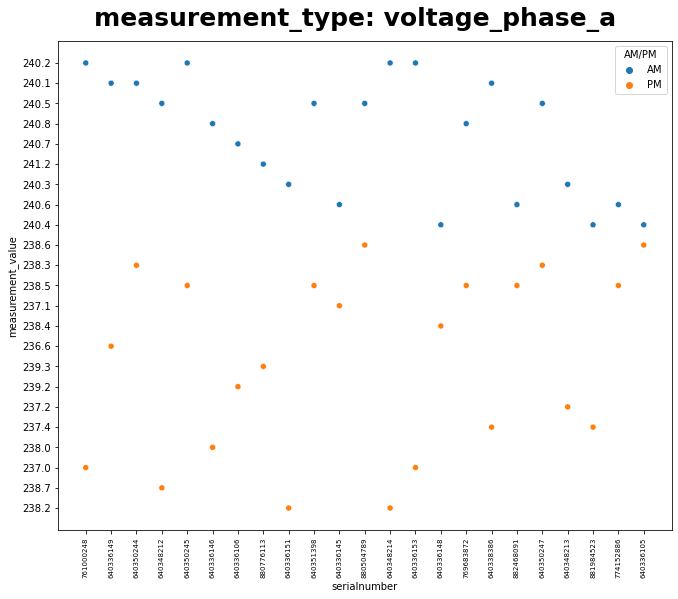

In [23]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.scatterplot(ax=ax, x='serialnumber', y='measurement_value', 
                data=df_usage_inst[df_usage_inst['measurement_type']=='voltage_phase_a'], 
                hue='AM/PM')
ax.tick_params(axis='x', labelrotation=90, labelsize=7.0);
fig.suptitle(f'measurement_type: voltage_phase_a', fontsize=25, fontweight='bold')
plt.subplots_adjust(top=0.925)
fig_num +=1

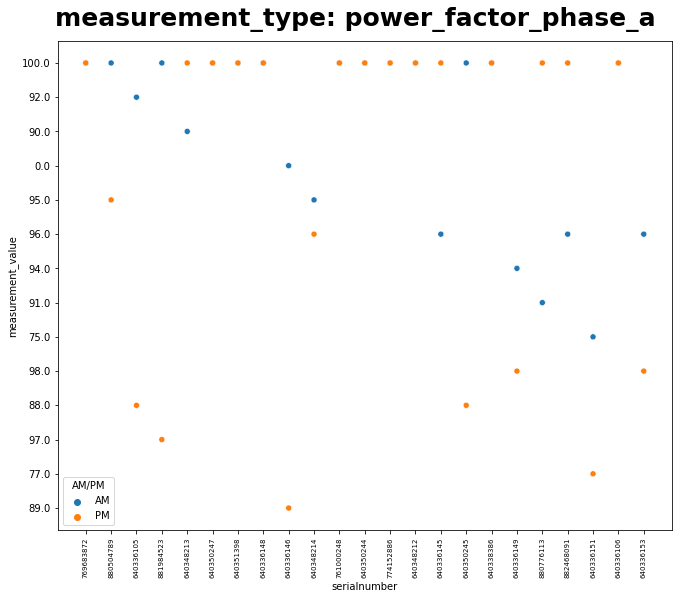

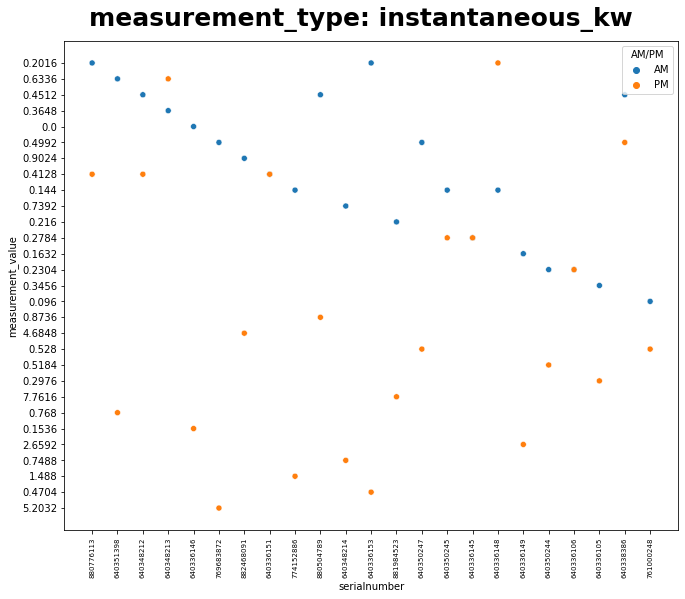

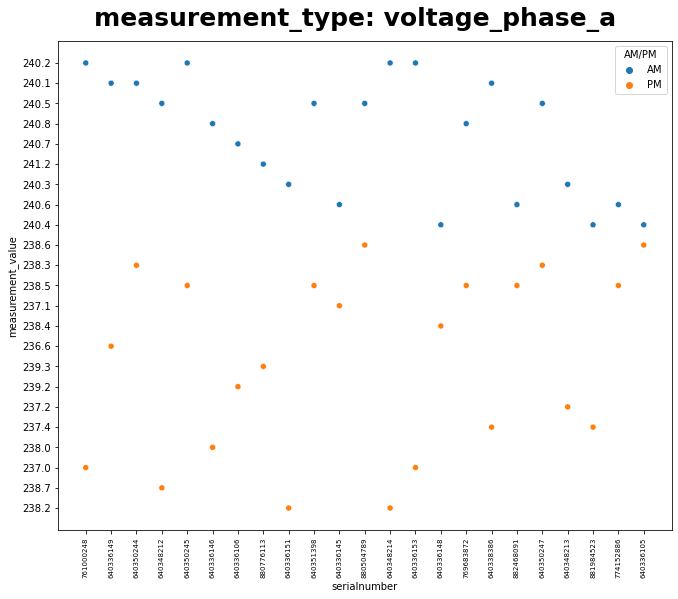

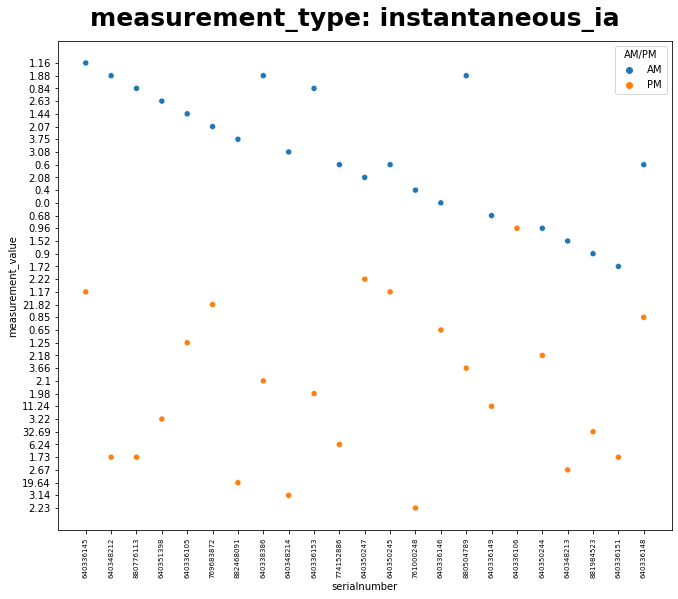

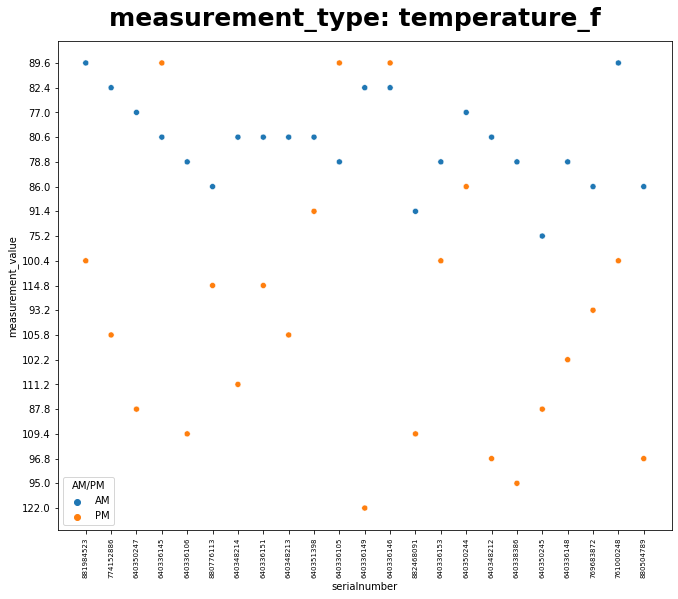

In [24]:
measurement_types = df_usage_inst['measurement_type'].unique().tolist()
for measurement_type in measurement_types:
    fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
    sns.scatterplot(ax=ax, x='serialnumber', y='measurement_value', 
                    data=df_usage_inst[df_usage_inst['measurement_type']==measurement_type], 
                    hue='AM/PM')
    ax.tick_params(axis='x', labelrotation=90, labelsize=7.0);
    fig.suptitle(f'measurement_type: {measurement_type}', fontsize=25, fontweight='bold')
    plt.subplots_adjust(top=0.925)
    fig_num +=1

# ---------------------------------------------------------------
# INSTANTANEOUS
# ---------------------------------------------------------------

In [25]:
cols_of_interest_inst = [
    'meter_id', 
    'read_time', 
    'read_date', 
    'msr_value', 
    'msr_type'
]

sql_inst = (
"""
WITH INST AS (
    SELECT {}
    FROM instantaneous.inst_msr_consume
    WHERE opco_cd = 'oh' 
    AND read_date IN ({})
), 
MP AS (
    SELECT {}
    FROM default.meter_premise
    WHERE state_cd IN ({})
    AND prem_nb IN ({})
)

SELECT {}
FROM INST
INNER JOIN MP
ON INST.meter_id = MP.mfr_devc_ser_nbr
"""
).format(','.join(cols_of_interest_inst), 
         ','.join(["'{}'".format(x) for x in dates_of_outages]), 
         ','.join(cols_of_interest_met_prem),          
         ','.join(["'{}'".format(x) for x in df_outage['STATE_ABBR_TX'].unique().tolist()]), 
         ','.join(["'{}'".format(x) for x in df_outage['PREMISE_NB'].unique().tolist()]), 
         ','.join([f'INST.{x} AS {x}' for x in cols_of_interest_inst] + [f'MP.{x} AS {x}' for x in cols_of_interest_met_prem]))

print(sql_inst)


WITH INST AS (
    SELECT meter_id,read_time,read_date,msr_value,msr_type
    FROM instantaneous.inst_msr_consume
    WHERE opco_cd = 'oh' 
    AND read_date IN ('2020-10-12')
), 
MP AS (
    SELECT mfr_devc_ser_nbr,longitude,latitude,state_cd,prem_nb,srvc_pole_nb,trsf_pole_nb,latitude_nb,longitude_nb,station_nb,xfmr_nb
    FROM default.meter_premise
    WHERE state_cd IN ('OH')
    AND prem_nb IN ('100420620','100547600','100683783','101020620','101330620','103520620','103647600','103783783','104120620','104430620','105030620','105293783','105710620','106620620','106747600','106883783','107220620','107483783','108130620','108393783','108810620','109720620','109847600')
)

SELECT INST.meter_id AS meter_id,INST.read_time AS read_time,INST.read_date AS read_date,INST.msr_value AS msr_value,INST.msr_type AS msr_type,MP.mfr_devc_ser_nbr AS mfr_devc_ser_nbr,MP.longitude AS longitude,MP.latitude AS latitude,MP.state_cd AS state_cd,MP.prem_nb AS prem_nb,MP.srvc_pole_nb AS srvc_pole_nb,MP.trs

In [26]:
df_inst = pd.read_sql(sql_inst, conn_aws)
df_inst = Utilities_df.remove_prepend_from_columns_in_df(df_inst)

In [27]:
print(f'# Unique serial numbers: {len(df_inst["mfr_devc_ser_nbr"].unique())}')
print('Read times:')
print(*sorted(df_inst['read_time'].unique()), sep='\n')

# Unique serial numbers: 23
Read times:
03:30:25
03:30:47
03:31:23
03:31:26
03:31:40
03:32:10
03:32:11
03:32:50
03:33:51
03:33:55
03:33:57
03:34:08
03:35:08
03:35:24
03:35:39
03:36:00
03:36:19
03:37:00
03:37:13
03:37:45
03:38:05
03:38:20
03:38:28
17:01:19
17:01:22
17:01:41
17:01:47
17:02:28
17:02:31
17:02:48
17:03:02
17:03:52
17:03:56
17:03:58
17:04:29
17:04:58
17:05:00
17:05:28
17:06:02
17:06:28
17:06:31
17:06:42
17:07:43
17:07:49
17:07:52
17:09:13


In [28]:
df_inst['read_time'] = pd.to_datetime(df_inst['read_time'], format= '%H:%M:%S').dt.time

df_inst['AM/PM'] = None
df_inst.loc[df_inst['read_time'] < pd.to_datetime('12:00:00', format= '%H:%M:%S').time(), 'AM/PM'] = 'AM'
df_inst.loc[df_inst['read_time'] >= pd.to_datetime('12:00:00', format= '%H:%M:%S').time(), 'AM/PM'] = 'PM'

In [29]:
df_inst

,meter_id,read_time,read_date,msr_value,msr_type,mfr_devc_ser_nbr,longitude,latitude,state_cd,prem_nb,srvc_pole_nb,trsf_pole_nb,latitude_nb,longitude_nb,station_nb,xfmr_nb,AM/PM
0,640336105,03:31:26,2020-10-12,0.345600,InstkW,640336105,-82.9537700,40.06837000,OH,104120620,1872854753620,1872854753620,40.06837000,-82.9537700,0009,,AM
1,640336105,03:31:26,2020-10-12,1.440000,InstAMPsCalc,640336105,-82.9537700,40.06837000,OH,104120620,1872854753620,1872854753620,40.06837000,-82.9537700,0009,,AM
2,640336105,17:03:52,2020-10-12,0.297600,InstkW,640336105,-82.9537700,40.06837000,OH,104120620,1872854753620,1872854753620,40.06837000,-82.9537700,0009,,PM
3,640336105,17:03:52,2020-10-12,88.000000,PowerFactorMeter,640336105,-82.9537700,40.06837000,OH,104120620,1872854753620,1872854753620,40.06837000,-82.9537700,0009,,PM
4,640336105,17:03:52,2020-10-12,238.600006,VoltageA,640336105,-82.9537700,40.06837000,OH,104120620,1872854753620,1872854753620,40.06837000,-82.9537700,0009,,PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,882468091,03:34:08,2020-10-12,91.400002,TempF,882468091,-82.9535730,40.06827500,OH,108130620,1873015753590,1873015753590,40.06827500,-82.9535730,0009,,AM
226,882468091,17:02:28,2020-10-12,4.684800,InstkW,882468091,-82.9535730,40.06827500,OH,108130620,1873015753590,1873015753590,40.06827500,-82.9535730,0009,,PM
227,882468091,17:02:28,2020-10-12,19.639999,InstAMPsCalc,882468091,-82.9535730,40.06827500,OH,108130620,1873015753590,1873015753590,40.06827500,-82.9535730,0009,,PM
228,882468091,17:02:28,2020-10-12,109.400002,TempF,882468091,-82.9535730,40.06827500,OH,108130620,1873015753590,1873015753590,40.06827500,-82.9535730,0009,,PM


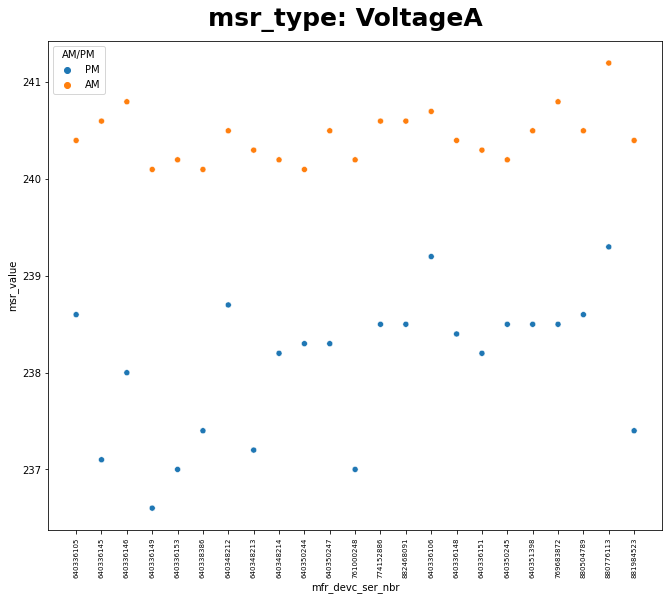

In [30]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.scatterplot(ax=ax, x='mfr_devc_ser_nbr', y='msr_value', data=df_inst[df_inst['msr_type']=='VoltageA'], 
                hue='AM/PM')
ax.tick_params(axis='x', labelrotation=90, labelsize=7.0);
fig.suptitle(f'msr_type: VoltageA', fontsize=25, fontweight='bold')
plt.subplots_adjust(top=0.925)
fig_num +=1

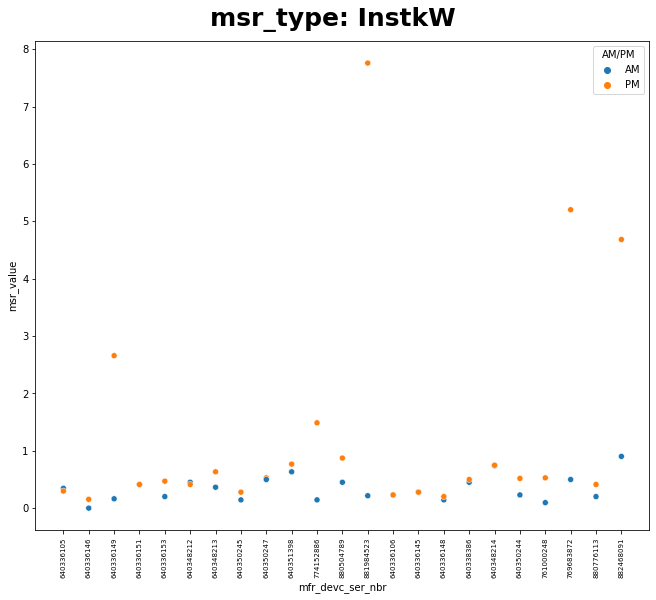

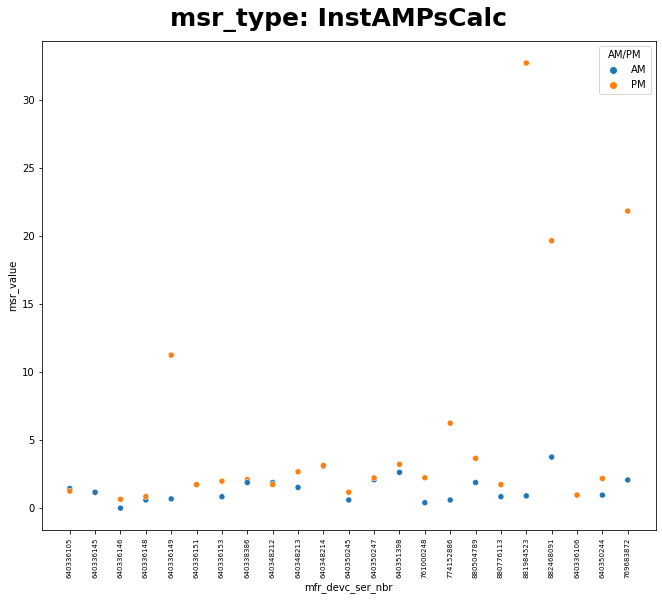

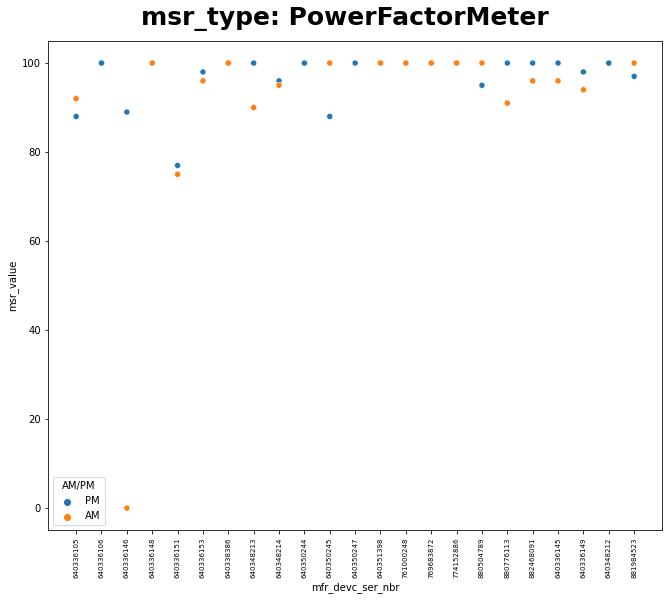

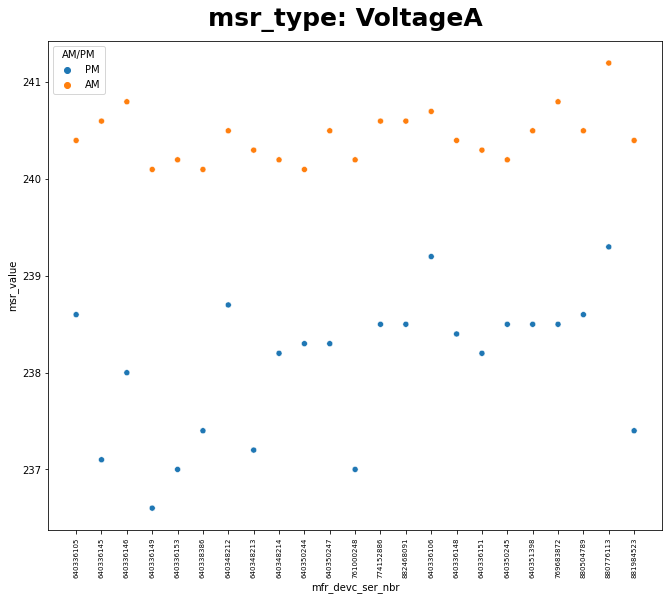

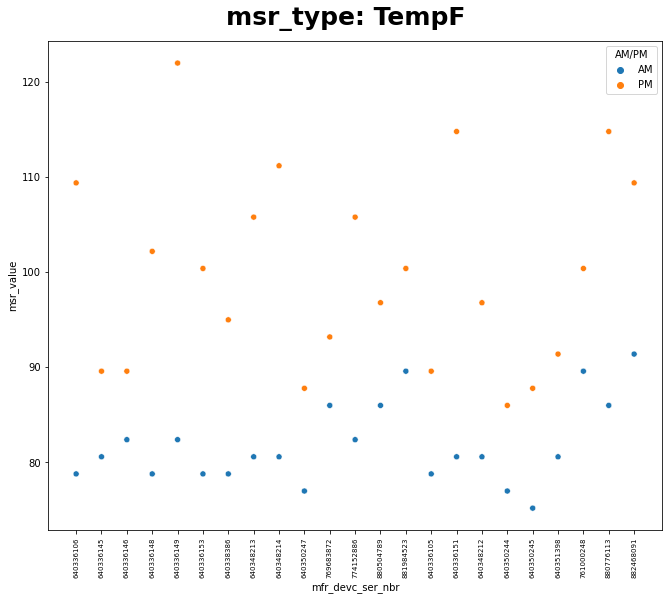

In [31]:
msr_types = df_inst['msr_type'].unique().tolist()
for msr_type in msr_types:
    fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
    sns.scatterplot(ax=ax, x='mfr_devc_ser_nbr', y='msr_value', data=df_inst[df_inst['msr_type']==msr_type], 
                    hue='AM/PM')
    ax.tick_params(axis='x', labelrotation=90, labelsize=7.0);
    fig.suptitle(f'msr_type: {msr_type}', fontsize=25, fontweight='bold')
    plt.subplots_adjust(top=0.925)
    fig_num +=1

# ---------------------------------------------------------------
# USAGE NONVEE
# ---------------------------------------------------------------

In [32]:
cols_of_interest_usage = [
    'serialnumber', 
    'starttimeperiod', 
    'endtimeperiod', 
    'aep_endtime_utc', 
    'timezoneoffset', 
    'aep_srvc_qlty_idntfr', 
    'value', 
    'aep_opco', 
    'aep_usage_dt']

In [33]:
sql_usage = (
"""
WITH U AS (
    SELECT {}
    FROM usage_nonvee.reading_ivl_nonvee
    WHERE aep_opco = 'oh' 
    AND aep_premise_nb IN ({})
    AND aep_usage_dt IN ({})
    AND aep_derived_uom = 'VOLT'
),
MP AS (
    SELECT {}
    FROM default.meter_premise
)

SELECT {}
FROM U
INNER JOIN MP
ON U.serialnumber = MP.mfr_devc_ser_nbr
"""
).format(','.join(cols_of_interest_usage), 
         ','.join(["'{}'".format(x) for x in df_outage['PREMISE_NB'].unique().tolist()]), 
         ','.join(["'{}'".format(x) for x in dates_of_outages]), 
         ','.join(cols_of_interest_met_prem), 
         ','.join([f'MP.{x} AS {x}' for x in cols_of_interest_met_prem] + [f'U.{x} AS {x}' for x in cols_of_interest_usage]))

print(sql_usage)


WITH U AS (
    SELECT serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value,aep_opco,aep_usage_dt
    FROM usage_nonvee.reading_ivl_nonvee
    WHERE aep_opco = 'oh' 
    AND aep_premise_nb IN ('100420620','100547600','100683783','101020620','101330620','103520620','103647600','103783783','104120620','104430620','105030620','105293783','105710620','106620620','106747600','106883783','107220620','107483783','108130620','108393783','108810620','109720620','109847600')
    AND aep_usage_dt IN ('2020-10-12')
    AND aep_derived_uom = 'VOLT'
),
MP AS (
    SELECT mfr_devc_ser_nbr,longitude,latitude,state_cd,prem_nb,srvc_pole_nb,trsf_pole_nb,latitude_nb,longitude_nb,station_nb,xfmr_nb
    FROM default.meter_premise
)

SELECT MP.mfr_devc_ser_nbr AS mfr_devc_ser_nbr,MP.longitude AS longitude,MP.latitude AS latitude,MP.state_cd AS state_cd,MP.prem_nb AS prem_nb,MP.srvc_pole_nb AS srvc_pole_nb,MP.trsf_pole_nb AS trsf_pole_nb,MP.latitude_nb AS latit

In [34]:
df_usage = pd.read_sql(sql_usage, conn_aws)

In [35]:
df_usage['aep_srvc_qlty_idntfr'].unique()

array(['AVG'], dtype=object)

In [36]:
df_usage['starttimeperiod'] = df_usage['starttimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))
df_usage['endtimeperiod'] = df_usage['endtimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))

In [37]:
tmp_df = df_usage[(df_usage['starttimeperiod'] > pd.to_datetime('2020-10-12 18:00:00')) 
         & (df_usage['starttimeperiod'] < pd.to_datetime('2020-10-12 22:00:00'))].copy()

In [38]:
tmp_df['trsf_pole_nb'].unique()

array(['1873015753590', '1872854753620', '1872746753453', '1872975753765',
       '1872895753490'], dtype=object)

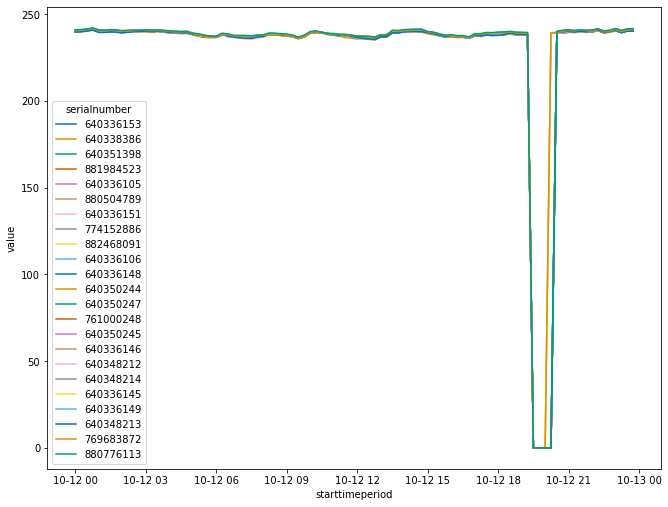

In [39]:
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
sns.lineplot(ax=ax, x='starttimeperiod', y='value', hue='serialnumber', data=df_usage, 
             palette='colorblind')
fig_num += 1

In [40]:
df_usage.sort_values(by = 'starttimeperiod')

,mfr_devc_ser_nbr,longitude,latitude,state_cd,prem_nb,srvc_pole_nb,trsf_pole_nb,latitude_nb,longitude_nb,station_nb,xfmr_nb,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value,aep_opco,aep_usage_dt
303,774152886,-82.9542970,40.06847800,OH,100420620,1872854753620,1872854753620,40.06847800,-82.9542970,0009,,774152886,2020-10-12 00:00:00,2020-10-12 00:15:00,1602476100,-04:00,AVG,240.600006,oh,2020-10-12
1296,769683872,-82.9537980,40.06877300,OH,103520620,1872975753765,1872975753765,40.06877300,-82.9537980,0009,,769683872,2020-10-12 00:00:00,2020-10-12 00:15:00,1602476100,-04:00,AVG,240.699997,oh,2020-10-12
342,640350244,-82.9542950,40.06809300,OH,106883783,1872746753453,1872746753453,40.06809300,-82.9542950,0009,,640350244,2020-10-12 00:00:00,2020-10-12 00:15:00,1602476100,-04:00,AVG,239.800003,oh,2020-10-12
887,640348213,-82.9547200,40.06797500,OH,107483783,1872746753453,1872746753453,40.06797500,-82.9547200,0009,,640348213,2020-10-12 00:00:00,2020-10-12 00:15:00,1602476100,-04:00,AVG,239.699997,oh,2020-10-12
2102,640336105,-82.9537700,40.06837000,OH,104120620,1872854753620,1872854753620,40.06837000,-82.9537700,0009,,640336105,2020-10-12 00:00:00,2020-10-12 00:15:00,1602476100,-04:00,AVG,240.399994,oh,2020-10-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,882468091,-82.9535730,40.06827500,OH,108130620,1873015753590,1873015753590,40.06827500,-82.9535730,0009,,882468091,2020-10-12 23:45:00,2020-10-13 00:00:00,1602561600,-04:00,AVG,240.800003,oh,2020-10-12
223,640336106,-82.9538850,40.06800200,OH,105710620,1872895753490,1872895753490,40.06800200,-82.9538850,0009,,640336106,2020-10-12 23:45:00,2020-10-13 00:00:00,1602561600,-04:00,AVG,241.500000,oh,2020-10-12
1797,640336105,-82.9537700,40.06837000,OH,104120620,1872854753620,1872854753620,40.06837000,-82.9537700,0009,,640336105,2020-10-12 23:45:00,2020-10-13 00:00:00,1602561600,-04:00,AVG,241.000000,oh,2020-10-12
750,640348214,-82.9539920,40.06860000,OH,109847600,1872785753626,1872854753620,40.06860000,-82.9539920,0009,,640348214,2020-10-12 23:45:00,2020-10-13 00:00:00,1602561600,-04:00,AVG,240.699997,oh,2020-10-12


In [41]:
df_usage_inst['serialnumber'].unique()

array(['769683872', '880504789', '880776113', '640351398', '761000248',
       '640336105', '640348212', '640336145', '640348213', '881984523',
       '640336149', '774152886', '640350247', '640350244', '640336146',
       '640350245', '640336106', '882468091', '640338386', '640348214',
       '640336153', '640336151', '640336148'], dtype=object)

In [42]:
df_usage['serialnumber'].unique()

array(['640336153', '640338386', '640351398', '881984523', '640336105',
       '880504789', '640336151', '774152886', '882468091', '640336106',
       '640336148', '640350244', '640350247', '761000248', '640350245',
       '640336146', '640348212', '640348214', '640336145', '640336149',
       '640348213', '769683872', '880776113'], dtype=object)

In [43]:
df_usage_inst['serialnumber'].unique()==df_usage['serialnumber'].unique()

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False])

In [44]:
diffs = Utilities.get_two_lists_diff(df_usage_inst['serialnumber'].unique().tolist(), df_usage['serialnumber'].unique().tolist())

In [45]:
diffs

[]

# ---------------------------------------------------------------
# END DEVICE EVENTS
# ---------------------------------------------------------------

In [46]:
# cols_of_interest_end_dev_event = [
#     '*'
# ]


cols_of_interest_end_dev_event = [
    'issuertracking_id',    
    'serialnumber',
    'enddeviceeventtypeid',
    'valuesinterval',
    'aep_premise_nb',
    'reason',
    'event_type',
    'longitude',
    'latitude',
    'aep_opco',
    'aep_event_dt'    
]

In [47]:
sql_end_dev_event = (
"""
SELECT {}
FROM meter_events.end_device_event
WHERE serialnumber in ({})
AND aep_event_dt IN ({})
"""
).format(','.join(cols_of_interest_end_dev_event), 
         ','.join(["'{}'".format(x) for x in df_usage['serialnumber'].unique().tolist()]), 
         ','.join(["'{}'".format(x) for x in dates_of_outages]))
print(sql_end_dev_event)


SELECT issuertracking_id,serialnumber,enddeviceeventtypeid,valuesinterval,aep_premise_nb,reason,event_type,longitude,latitude,aep_opco,aep_event_dt
FROM meter_events.end_device_event
WHERE serialnumber in ('640336153','640338386','640351398','881984523','640336105','880504789','640336151','774152886','882468091','640336106','640336148','640350244','640350247','761000248','640350245','640336146','640348212','640348214','640336145','640336149','640348213','769683872','880776113')
AND aep_event_dt IN ('2020-10-12')



In [48]:
df_end_dev_event = pd.read_sql(sql_end_dev_event, conn_aws)
df_end_dev_event = Utilities_df.remove_prepend_from_columns_in_df(df_end_dev_event)

In [55]:
df_end_dev_event

,issuertracking_id,serialnumber,enddeviceeventtypeid,valuesinterval,aep_premise_nb,reason,event_type,longitude,latitude,aep_opco,aep_event_dt
0,1-1483500337,640336153,3.26.136.47,2020-10-12T19:18:56.000-04:00,106747600,Last Gasp - NIC power lost for device: 00:13:5...,3,-82.9541130,40.06865200,oh,2020-10-12
1,1-1483595448,640336153,3.26.0.47,2020-10-12T19:18:46.000-04:00,106747600,Primary Power Down occurred for meter 00:13:50...,3,-82.9541130,40.06865200,oh,2020-10-12
2,1-1483595449,640336153,3.26.0.216,2020-10-12T20:41:59.000-04:00,106747600,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9541130,40.06865200,oh,2020-10-12
3,1-1483661332,640336151,3.26.0.47,2020-10-12T19:18:55.000-04:00,103647600,Primary Power Down occurred for meter 00:13:50...,3,-82.9544100,40.06841200,oh,2020-10-12
4,1-1483661333,640336151,3.26.0.216,2020-10-12T20:42:09.000-04:00,103647600,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9544100,40.06841200,oh,2020-10-12
...,...,...,...,...,...,...,...,...,...,...,...
58,7-1483648072,761000248,3.26.0.47,2020-10-12T19:18:40.000-04:00,104430620,Primary Power Down occurred for meter 00:13:50...,3,-82.9531500,40.06822800,oh,2020-10-12
59,7-1483648073,761000248,3.26.0.216,2020-10-12T20:41:53.000-04:00,104430620,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9531500,40.06822800,oh,2020-10-12
60,7-1483704870,640350247,3.26.0.47,2020-10-12T19:18:50.000-04:00,108393783,Primary Power Down occurred for meter 00:13:50...,3,-82.9539080,40.06816300,oh,2020-10-12
61,7-1483704871,640350247,3.26.0.216,2020-10-12T20:42:02.000-04:00,108393783,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9539080,40.06816300,oh,2020-10-12


In [50]:
len(df_usage['serialnumber'].unique())

23

In [51]:
len(df_end_dev_event['serialnumber'].unique())

23

In [56]:
df_end_dev_event['valuesinterval2'] = pd.to_datetime(df_end_dev_event['valuesinterval'])

In [57]:
df_end_dev_event

,issuertracking_id,serialnumber,enddeviceeventtypeid,valuesinterval,aep_premise_nb,reason,event_type,longitude,latitude,aep_opco,aep_event_dt,valuesinterval2
0,1-1483500337,640336153,3.26.136.47,2020-10-12T19:18:56.000-04:00,106747600,Last Gasp - NIC power lost for device: 00:13:5...,3,-82.9541130,40.06865200,oh,2020-10-12,2020-10-12 19:18:56-04:00
1,1-1483595448,640336153,3.26.0.47,2020-10-12T19:18:46.000-04:00,106747600,Primary Power Down occurred for meter 00:13:50...,3,-82.9541130,40.06865200,oh,2020-10-12,2020-10-12 19:18:46-04:00
2,1-1483595449,640336153,3.26.0.216,2020-10-12T20:41:59.000-04:00,106747600,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9541130,40.06865200,oh,2020-10-12,2020-10-12 20:41:59-04:00
3,1-1483661332,640336151,3.26.0.47,2020-10-12T19:18:55.000-04:00,103647600,Primary Power Down occurred for meter 00:13:50...,3,-82.9544100,40.06841200,oh,2020-10-12,2020-10-12 19:18:55-04:00
4,1-1483661333,640336151,3.26.0.216,2020-10-12T20:42:09.000-04:00,103647600,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9544100,40.06841200,oh,2020-10-12,2020-10-12 20:42:09-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...
58,7-1483648072,761000248,3.26.0.47,2020-10-12T19:18:40.000-04:00,104430620,Primary Power Down occurred for meter 00:13:50...,3,-82.9531500,40.06822800,oh,2020-10-12,2020-10-12 19:18:40-04:00
59,7-1483648073,761000248,3.26.0.216,2020-10-12T20:41:53.000-04:00,104430620,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9531500,40.06822800,oh,2020-10-12,2020-10-12 20:41:53-04:00
60,7-1483704870,640350247,3.26.0.47,2020-10-12T19:18:50.000-04:00,108393783,Primary Power Down occurred for meter 00:13:50...,3,-82.9539080,40.06816300,oh,2020-10-12,2020-10-12 19:18:50-04:00
61,7-1483704871,640350247,3.26.0.216,2020-10-12T20:42:02.000-04:00,108393783,Primary Power Up occurred for meter 00:13:50:0...,3,-82.9539080,40.06816300,oh,2020-10-12,2020-10-12 20:42:02-04:00


<AxesSubplot:>

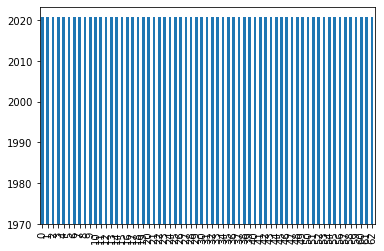

In [58]:
df_end_dev_event['valuesinterval2'].plot(kind='bar')

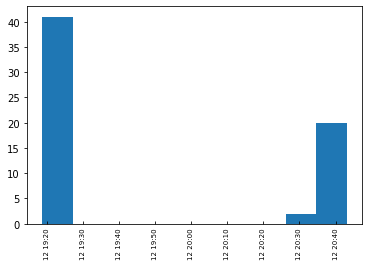

In [61]:
plt.hist(df_end_dev_event['valuesinterval2'])
plt.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in')

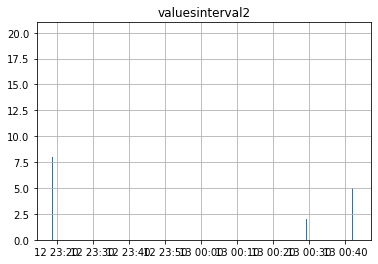

In [65]:
hist = df_end_dev_event.hist(column='valuesinterval2', bins=1000)

array([[<AxesSubplot:title={'center':'valuesinterval2'}>]], dtype=object)

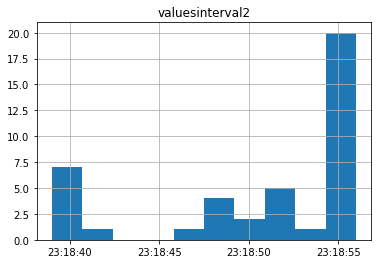

In [69]:
df_end_dev_event[df_end_dev_event['valuesinterval2'] < '2020-10-12 19:20:00'].hist(column='valuesinterval2')

array([[<AxesSubplot:title={'center':'valuesinterval2'}>]], dtype=object)

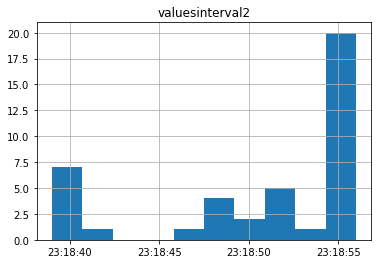

In [73]:
df_end_dev_event[df_end_dev_event['valuesinterval2'] < '2020-10-12 20:00:00'].hist(column='valuesinterval2')

In [74]:
df_end_dev_event['enddeviceeventtypeid'].unique()

array(['3.26.136.47', '3.26.0.47', '3.26.0.216'], dtype=object)

In [ ]:
possible_enddeviceeventtypeids = [
    '3.26.38.73', 
    '3.12.93.28',
    '3.26.38.150',
    '3.26.0.47',
    '3.7.19.243',
    '3.12.48.219',
    '3.18.72.79',
    '3.26.136.47',
    '3.7.19.242',
    '3.26.0.216',
    '3.26.38.93',
    '3.12.93.219',
    '3.18.72.28',
    '3.12.48.28',
    '3.26.38.37'
]